In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [40]:
train_raw = pd.read_csv('/kaggle/input/titanic/train.csv')
test_raw = pd.read_csv('/kaggle/input/titanic/test.csv')
test_ids = test_raw['PassengerId'].values

# Joining test and train set 
train_raw['train'] = 1
test_raw['train'] = 0
data = train_raw.append(test_raw, sort=False)

/tmp/ipykernel_32/4178901730.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = train_raw.append(test_raw, sort=False)


In [41]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [6]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
train             0
dtype: int64

In [42]:
#Replacing null values of Fare with median of their PClass (As Fare is dependent on passenger class)

pclass = data.loc[data.Fare.isnull(), 'Pclass'].values[0]
median_fare = data.loc[data.Pclass== pclass, 'Fare'].median()
data.loc[data.Fare.isnull(), 'Fare'] = median_fare

In [43]:
# To replace null values in Age, extracting Titles from names and using median ages for each title
data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=True)
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [44]:
# Title reduction to take care of synonymous titles
title_reduction = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 
                   'Master': 'Master', 'Don': 'Mr', 'Rev': 'Rev',
                   'Dr': 'Dr', 'Mme': 'Miss', 'Ms': 'Miss',
                   'Major': 'Mr', 'Lady': 'Mrs', 'Sir': 'Mr',
                   'Mlle': 'Miss', 'Col': 'Mr', 'Capt': 'Mr',
                   'Countess': 'Mrs','Jonkheer': 'Mr',
                   'Dona': 'Mrs'}
data['Title'] = data['Title'].map(title_reduction)
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'], dtype=object)

In [45]:
for title, age in data.groupby('Title')['Age'].median().items():
    print(title, age)
    data.loc[(data['Title']==title) & (data['Age'].isnull()), 'Age'] = age

Dr 49.0
Master 4.0
Miss 22.0
Mr 30.0
Mrs 36.0
Rev 41.5


In [46]:
data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
train             0
Title             0
dtype: int64

In [47]:
data.drop(['Cabin'], axis=1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,train,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,30.0,0,0,A.5. 3236,8.0500,S,0,Mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C,0,Mrs
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,S,0,Mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,30.0,0,0,359309,8.0500,S,0,Mr


In [83]:
features = ['Age', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp']
target = 'Survived'

data = data[features + [target] + ['train']]
#Categorical values need  transformed into numeric.
data['Sex'] = data['Sex'].replace(["female", "male"], [0, 1])
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])


In [50]:
data['Age'] = pd.qcut(data['Age'], 10, labels=False, duplicates='drop')

In [51]:
train_raw.dropna(axis=0, inplace=True)
labels = train_raw[target].values

In [52]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,1
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,1


In [53]:
data.head(15)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2,1.0,7.2500,0,3,1,1,0.0,1
1,6,2.0,71.2833,0,1,0,1,1.0,1
2,3,1.0,7.9250,0,3,0,0,1.0,1
3,6,1.0,53.1000,0,1,0,1,1.0,1
4,6,1.0,8.0500,0,3,1,0,0.0,1
5,4,3.0,8.4583,0,3,1,0,0.0,1
6,8,1.0,51.8625,0,1,1,0,0.0,1
7,0,1.0,21.0750,1,3,1,3,0.0,1
8,4,1.0,11.1333,2,3,0,0,1.0,1
9,0,2.0,30.0708,0,2,0,1,1.0,1


In [54]:
train = data.query('train == 1')
test = data.query('train == 0')


train.dropna(axis=0, inplace=True)
labels = train[target].values

/tmp/ipykernel_32/3320870142.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(axis=0, inplace=True)


In [55]:
train.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,train
0,2,1.0,7.2500,0,3,1,1,0.0,1
1,6,2.0,71.2833,0,1,0,1,1.0,1
2,3,1.0,7.9250,0,3,0,0,1.0,1
3,6,1.0,53.1000,0,1,0,1,1.0,1
4,6,1.0,8.0500,0,3,1,0,0.0,1


               Age  Embarked      Fare     Parch    Pclass       Sex  \
Age       1.000000 -0.043549  0.111624 -0.150556 -0.355081  0.090695   
Embarked -0.043549  1.000000  0.063462 -0.079320  0.043835 -0.118593   
Fare      0.111624  0.063462  1.000000  0.217532 -0.548193 -0.179958   
Parch    -0.150556 -0.079320  0.217532  1.000000  0.016824 -0.247508   
Pclass   -0.355081  0.043835 -0.548193  0.016824  1.000000  0.127741   
Sex       0.090695 -0.118593 -0.179958 -0.247508  0.127741  1.000000   
SibSp    -0.236499 -0.060606  0.160887  0.414542  0.081656 -0.116348   
Survived -0.038936  0.108669  0.255290  0.083151 -0.335549 -0.541585   
train          NaN       NaN       NaN       NaN       NaN       NaN   

             SibSp  Survived  train  
Age      -0.236499 -0.038936    NaN  
Embarked -0.060606  0.108669    NaN  
Fare      0.160887  0.255290    NaN  
Parch     0.414542  0.083151    NaN  
Pclass    0.081656 -0.335549    NaN  
Sex      -0.116348 -0.541585    NaN  
SibSp     1.0

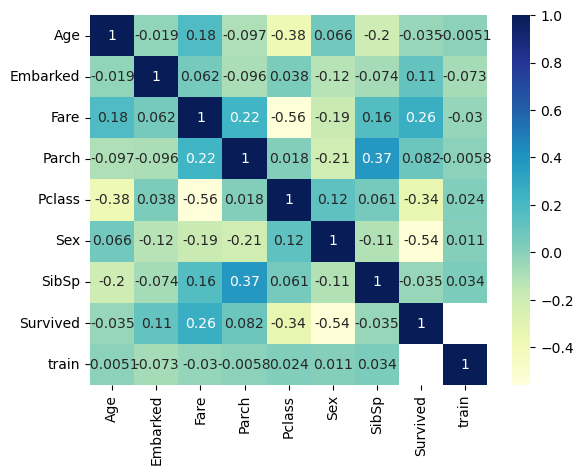

In [56]:
import seaborn as sb
import matplotlib.pyplot as mt
  

print(train.corr())
  
# plotting correlation heatmap
dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
mt.show()

In [57]:
# As Fare and Pclass are highly -vely coordinated, we can remove Pclass
train.drop(['train',  'Pclass'], axis=1, inplace=True)
test.drop(['train', 'Pclass'], axis=1, inplace=True)

/tmp/ipykernel_32/3173161247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['train',  'Pclass'], axis=1, inplace=True)
/tmp/ipykernel_32/3173161247.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['train', 'Pclass'], axis=1, inplace=True)


In [58]:
train.head(10)

,Age,Embarked,Fare,Parch,Sex,SibSp,Survived
0,2,1.0,7.2500,0,1,1,0.0
1,6,2.0,71.2833,0,0,1,1.0
2,3,1.0,7.9250,0,0,0,1.0
3,6,1.0,53.1000,0,0,1,1.0
4,6,1.0,8.0500,0,1,0,0.0
5,4,3.0,8.4583,0,1,0,0.0
6,8,1.0,51.8625,0,1,0,0.0
7,0,1.0,21.0750,1,1,3,0.0
8,4,1.0,11.1333,2,0,0,1.0
9,0,2.0,30.0708,0,0,1,1.0


In [59]:
test.head(10)

,Age,Embarked,Fare,Parch,Sex,SibSp,Survived
0,6,3.0,7.8292,0,1,0,NaN
1,7,1.0,7.0000,0,0,1,NaN
2,8,3.0,9.6875,0,1,0,NaN
3,4,1.0,8.6625,0,1,0,NaN
4,2,1.0,12.2875,1,0,1,NaN
5,0,1.0,9.2250,0,1,0,NaN
6,4,3.0,7.6292,0,0,0,NaN
7,3,1.0,29.0000,1,1,1,NaN
8,1,2.0,7.2292,0,0,0,NaN
9,1,1.0,24.1500,0,1,2,NaN


In [60]:
test.drop('Survived', axis=1)

,Age,Embarked,Fare,Parch,Sex,SibSp
0,6,3.0,7.8292,0,1,0
1,7,1.0,7.0000,0,0,1
2,8,3.0,9.6875,0,1,0
3,4,1.0,8.6625,0,1,0
4,2,1.0,12.2875,1,0,1
...,...,...,...,...,...,...
413,4,1.0,8.0500,0,1,0
414,6,2.0,108.9000,0,0,0
415,6,1.0,7.2500,0,1,0
416,4,1.0,8.0500,0,1,0


In [61]:
#probabilities of the features
    
Age_counts=train['Age'].value_counts()  
Age=Age_counts/len(train)

Embarked_counts=train['Embarked'].value_counts()  
Embarked=Embarked_counts/len(train)

Fare_counts=train['Fare'].value_counts()  
Fare=Fare_counts/len(train)

Parch_counts=train['Parch'].value_counts()  
Parch=Parch_counts/len(train)

Sex_counts=train['Sex'].value_counts()  
Sex=Sex_counts/len(train)

SibSp_counts=train['SibSp'].value_counts()  
SibSp=SibSp_counts/len(train)

Survived=train.loc[train['Survived'] == 1]
Died=train.loc[train['Survived'] == 0]


y_counts=train['Survived'].value_counts()
p_y=y_counts/len(train)

#Conditional Probabilities

age_survived_counts=Survived['Age'].value_counts()  
p_age_survived=age_survived_counts/len(Survived)

age_died_counts=Died['Age'].value_counts()  
p_age_died=age_died_counts/len(Died)

Embarked_survived_counts=Survived['Embarked'].value_counts()  
p_Embarked_survived=Embarked_survived_counts/len(Survived)

Embarked_died_counts=Died['Embarked'].value_counts()  
p_Embarked_died=Embarked_died_counts/len(Died)

Fare_survived_counts=Survived['Fare'].value_counts()  
p_Fare_survived=Fare_survived_counts/len(Survived)

Fare_died_counts=Died['Fare'].value_counts()  
p_Fare_died=Fare_died_counts/len(Died)

Parch_survived_counts=Survived['Parch'].value_counts()  
p_Parch_survived=Parch_survived_counts/len(Survived)

Parch_died_counts=Died['Parch'].value_counts()  
p_Parch_died=Parch_died_counts/len(Died)


Sex_survived_counts=Survived['Sex'].value_counts()  
p_Sex_survived=Sex_survived_counts/len(Survived)

Sex_died_counts=Died['Sex'].value_counts()  
p_Sex_died=Sex_died_counts/len(Died)


SibSp_survived_counts=Survived['SibSp'].value_counts()  
p_SibSp_survived=SibSp_survived_counts/len(Survived)

SibSp_died_counts=Died['SibSp'].value_counts()  
p_SibSp_died=SibSp_died_counts/len(Died)




In [67]:
def Naive_Bayes(py, px1_y, px2_y, px3_y, px1, px2, px3): #, px4_y,px5_y, px6_y, px1, px2, px3, px4, px5, px6):
    numerator=px1_y*px2_y*px3_y*py#px4_y*px5_y*px6_y*py
    denominator= px1*px2*px3#*px4*px5*px6
    p=numerator/denominator
    return p

In [89]:
arr=[]

for i in range(0,418):
    feature_Embarked=test.iloc[i]['Embarked']
    feature_sex=test.iloc[i]['Sex']
    feature_age=test.iloc[i]['Age']
    feature_Parch=test.iloc[i]['Parch']
    feature_Fare=test.iloc[i]['Fare']
    feature_SibSp=test.iloc[i]['SibSp']
    
    P_Y1=Naive_Bayes(p_y[1], p_Embarked_survived[feature_Embarked], p_Sex_survived[feature_sex], p_age_survived[feature_age], Embarked[feature_Embarked], Sex[feature_sex], Age[feature_age])#, p_Parch_survived[feature_Parch],p_Fare_survived[feature_Fare], p_SibSp_survived[feature_SibSp], Embarked[feature_Embarked], Sex[feature_sex], Age[feature_age], Parch[feature_Parch],Fare[feature_Fare], SibSp[feature_SibSp] )
    P_Y0=Naive_Bayes(p_y[0], p_Embarked_died[feature_Embarked], p_Sex_died[feature_sex], p_age_died[feature_age], Embarked[feature_Embarked], Sex[feature_sex], Age[feature_age])#, p_Parch_died[feature_Parch], p_Fare_died[feature_Fare], p_SibSp_died[feature_SibSp], Embarked[feature_Embarked], Sex[feature_sex], Age[feature_age], Parch[feature_Parch],Fare[feature_Fare], SibSp[feature_SibSp])
    
    if P_Y0 > P_Y1:
        sr=0
    else:
        sr=1
        
    arr.append(sr)


print(arr)
print(len(arr))
pred = pd.DataFrame({'PassengerId':test_raw.PassengerId,'Survived': arr})
print(pred)

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 


for dataset in data:
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7